# CSV/Excel Analysis Agent


## Overview

This tutorial covers how to create an agent that performs analysis on the `Pandas` DataFrame loaded from CSV or Excel files. The agent generates `Pandas` queries to analyze the dataset.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Sample Data](#sample-data)
- [Create an Analysis Agent](#create-an-analysis-agent)

### References
- [LangChain Documentation : create_pandas_dataframe_agent](https://python.langchain.com/api_reference/experimental/agents/langchain_experimental.agents.agent_toolkits.pandas.base.create_pandas_dataframe_agent.html)
----

## Environment Setup


In [1]:
# import getenv
import os
import getpass
import dotenv
# Load environment variables from .env file
dotenv.load_dotenv()
# Import Azure OpenAI
from langchain_openai import AzureChatOpenAI
from IPython.display import Markdown
from langchain_core.messages import HumanMessage, SystemMessage

## Sample Data

Document Used for Practice : **Titanic Dataset**
- File Name : titanic.csv
- Link : [Stanford CS109 Material](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/)
- Reference : [Titanic - Machine Learning from Disaster (Kaggle)](https://www.kaggle.com/c/titanic/data)

*Please copy the downloaded file to the data folder for practice.*

In [2]:
import pandas as pd

# Load CSV file
df = pd.read_csv("./data/titanic.csv")
# In case of loading an Excel file
# df = pd.read_excel("./data/titanic.xlsx", sheet_name="Sheet1")
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


## Create an Analysis Agent

Define an agent to analyze the data loaded from CSV or Excel files using `create_pandas_dataframe_agent` . 

This agent needs a `PythonAstREPLTool` to execute Python codes. Also, a custom function is defined to print the intermediate steps of the agent execution.

In [3]:
from langchain_experimental.tools import PythonAstREPLTool

# Create a tool to execute Python codes.
python_tool = PythonAstREPLTool()

# Load the DataFrame on locals["df"]
python_tool.locals["df"] = df

In [ ]:
#%pip install tabulate
#%pip install seaborn

In [4]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import AzureChatOpenAI

# Create an agent
agent = create_pandas_dataframe_agent(
    AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
),
    df,
    verbose=False,
    agent_type="tool-calling",
    allow_dangerous_code=True,
    prefix="You are a professional data analyst. "
    "You must use Pandas DataFrame(`df`) to answer user's queries. "
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
    "For visualization of the analyzed result, please use `plt.show()` at the end of your code. "
    "I prefer seaborn for visualization, but you can use matplotlib as well."
    "\n\n<Visualization Preference>\n"
    "- `muted` cmap, white background, and no grid for your visualization."
    "\nRecomment to set palette parameter for seaborn plot.",  # Add additional instructions to the default prompt
)

In [5]:
from langchain_core.agents import AgentStep


# Define a function to stream intermediate steps of executing the agent.
def stream_response(query):
    response = agent.stream({"input": query})
    for step in response:
        if "actions" in step:
            if step["actions"][0].tool == "python_repl_ast":
                tool_input = step["actions"][0].tool_input
                for k, v in tool_input.items():
                    if k == "query":
                        print(f"---- Code Begins ----")
                        print(v)
                        result = python_tool.invoke({"query": v})
                        print(result)
                        print(f"---- Code Ends ----")
        elif "steps" in step:
            print(f"---- Message Begins ----")
            for observation in step["steps"]:
                if isinstance(observation, AgentStep):
                    print(getattr(observation, "observation", None))
            print(f"---- Message Ends ----")
        elif "output" in step:
            print(f"---- Final Answer Begins ----")
            print(step["output"])
            print(f"---- Final Answer Ends ----")

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='muted', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()
ValueError: could not convert string to float: 'Mr. Owen Harris Braund'
---- Code Ends ----
---- Message Begins ----
ValueError: could not convert string to float: 'Mr. Owen Harris Braund'
---- Message Ends ----
---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='muted', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()
KeyError: "'muted' is not a known colormap name"
---- Code Ends ----
---- Message Begins ----
KeyError: "'muted

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

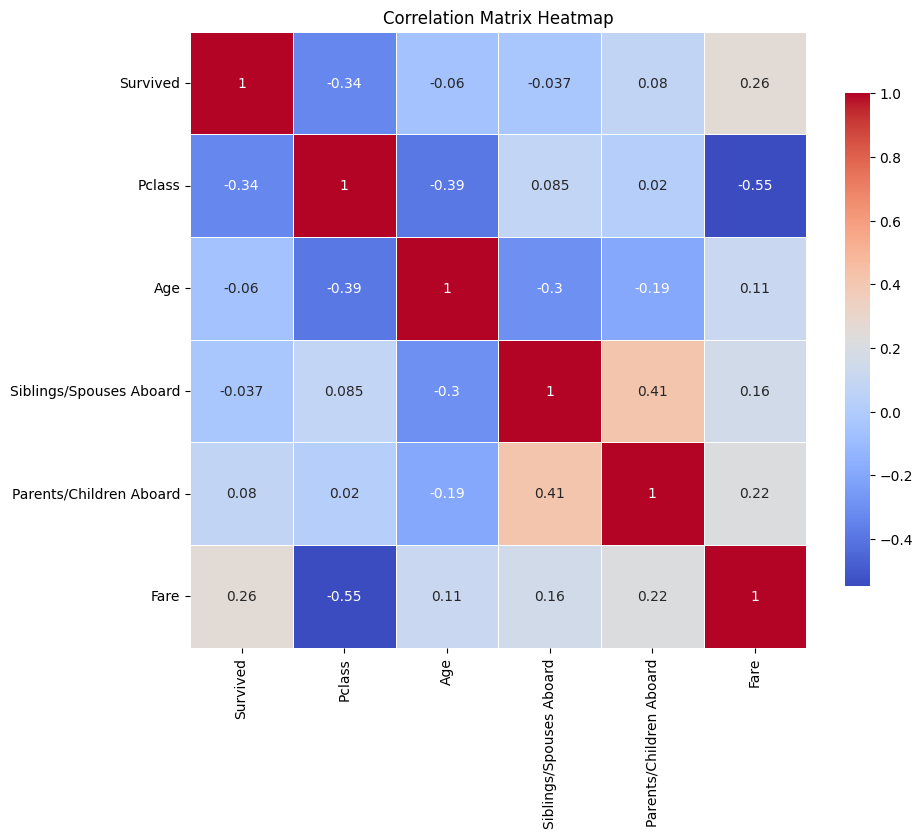

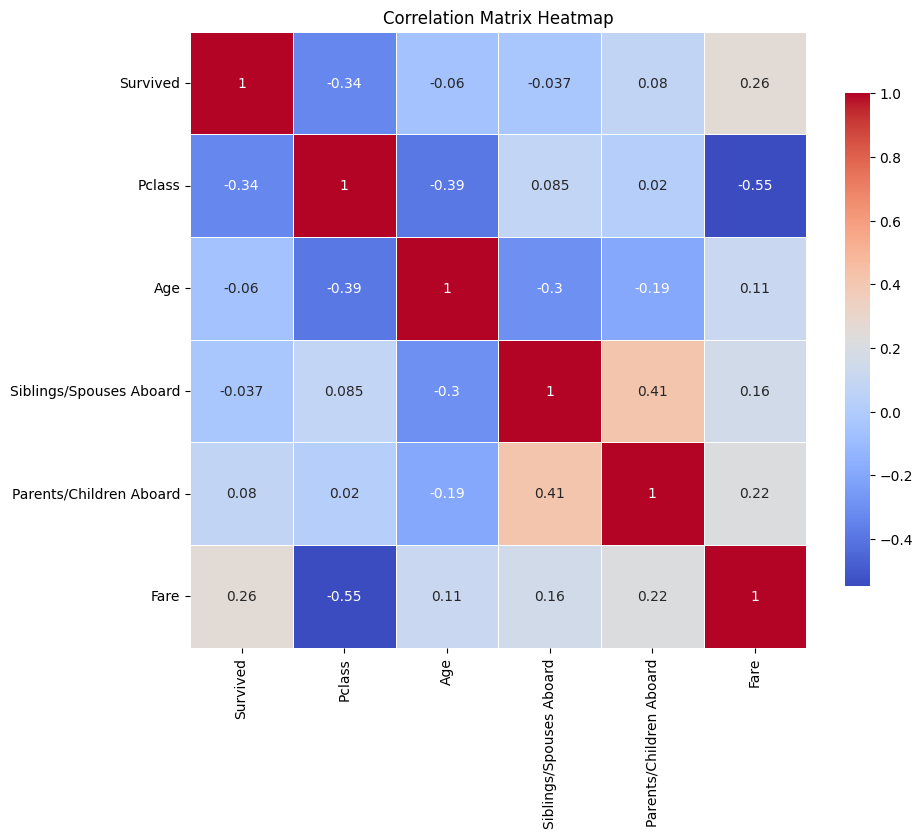

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, cbar_kws={'shrink': .8}, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

---- Code Ends ----
---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
The heatmap visualizing the correlation matrix has been displayed successfully using the `coolwarm` colormap. Let me know if you need further assistance or prefer adjustments in style or details.
---- Final Answer Ends ----


In [6]:
stream_response("Visualize correlations as a heatmap.")

In [7]:
stream_response("How many rows are there?")

---- Code Begins ----
len(df)
887
---- Code Ends ----
---- Message Begins ----
887
---- Message Ends ----
---- Final Answer Begins ----
The DataFrame contains 887 rows.
---- Final Answer Ends ----


---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate survival rates for men and women
survival_rates = df.groupby('Sex')['Survived'].mean()

# Plot the survival rates
sns.set_theme(style='white', palette='muted')
sns.barplot(x=survival_rates.index, y=survival_rates.values)
plt.ylabel('Survival Rate')
plt.xlabel('Sex')
plt.title('Survival Rates by Sex')
plt.show()

survival_rates


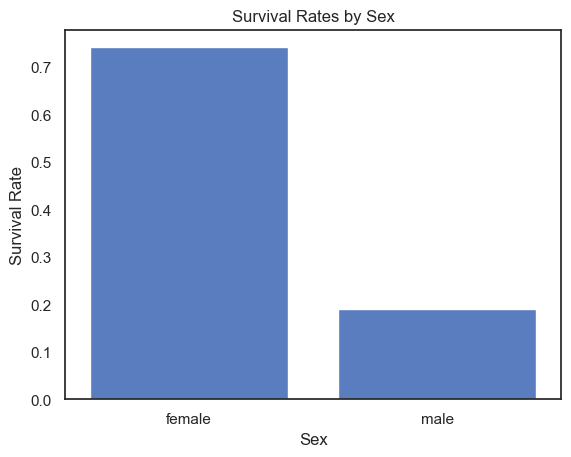

Sex
female    0.742038
male      0.190227
Name: Survived, dtype: float64
---- Code Ends ----


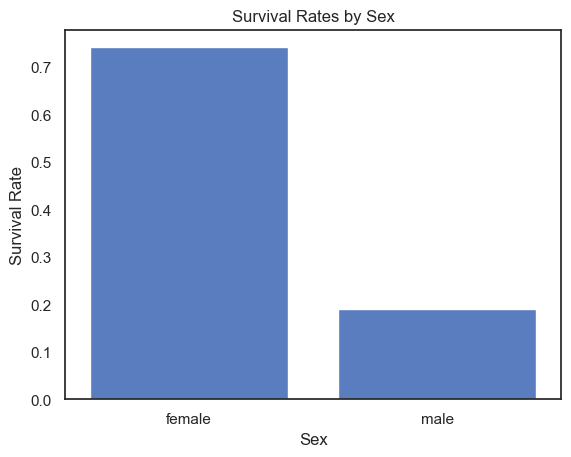

---- Message Begins ----
Sex
female    0.742038
male      0.190227
Name: Survived, dtype: float64
---- Message Ends ----
---- Final Answer Begins ----
The survival rates differ significantly between men and women:

- **Female survival rate**: 74.2%
- **Male survival rate**: 19.0%

This indicates that women had a much higher chance of survival compared to men. The visualization represents this difference effectively.
---- Final Answer Ends ----


In [8]:
stream_response("What is the difference in survival rates between men and women?")

In [ ]:
stream_response(
    "Visualize the survival rates of male and female passengers in a barplot."
)

In [ ]:
stream_response(
    "Visualize the survival rates of male and female children under 10 in 1st and 2nd class."
)

In [ ]:
stream_response(
    "what other visualization questions could I ask based on the contents of the CSV data file?."
)

In [ ]:
stream_response(
    "What is the distribution of family sizes aboard the Titanic?"
)